# Approximate solution to the traveling salesman problem

The Traveling Salesman Problem is a classical combinatorial optimization problem in which a salesman must visit a given set of cities exactly once and return to the starting city, while minimizing the total travel distance.

This project presents an approximation algorithm for the Traveling Salesman Problem in undirected weighted graphs that satisfy the triangle inequality. This approach is based on **Christofides–Serdyukov’s algorithm**. The algorithm provides a solution that is at most 1.5 times the length of the optimal solution (it has an approximation ratio of 1.5).

The algorithm combines some ideas from the **Chinese Postman Problem** and proceeds through the following steps:
1. Construction of a Minimum Spanning Tree
2. Identification of vertices with odd degree
3. Computation of a Minimum Weight Perfect Matching on the odd-degree vertices
4. Eulerian Circuit creation and shortcutting to find the Hamiltonian Cycle.

## Imports Section

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from queue import PriorityQueue
from copy import deepcopy
import itertools

## Classes: Graph and WeightedGraph 

In [9]:
class Graph:
    def __init__(self, graph=None):
        if graph is None:
            graph = {}
        self.graph = graph

    def add_vertex(self, vertex):
        if vertex not in self.graph:
            self.graph[vertex] = []

    def add_edge(self, edge):
        u, v = edge
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)
        if u not in self.graph[v]:
            self.graph[v].append(u)

    def __str__(self):
        res = ""
        for v in self.graph:
            res += f"{v}: {' '.join(map(str, self.graph[v]))}\n"
        return res

class WeightedGraph(Graph):
    def __init__(self, graph=None, weights=None):
        super().__init__(graph)
        if weights is None:
            weights = {}
        self.weights = weights

    def add_edge(self, edge, weight=1):
        super().add_edge(edge)
        u, v = edge
        self.weights[(u, v)] = weight
        self.weights[(v, u)] = weight

    def get_weight(self, u, v):
        return self.weights.get((u, v), float('inf'))

    def __str__(self):
        res = super().__str__()
        res += "------------------------\n"
        for v in self.graph:
            res += f"{v}: "
            for u in self.graph[v]:
                res += f"{u}({self.weights[(v, u)]}) "
            res += "\n"
        return res

    def min_spanning_tree(self):
        """
        Computes a minimum spanning tree. Starts from one point and adds the edges with the smallest weights.
        """
        if not self.graph:
            return WeightedGraph(), 0
        
        start_node = next(iter(self.graph))
        wtree = WeightedGraph()
        wtree.add_vertex(start_node)
        total_weight = 0
        pq = PriorityQueue()
        
        for neighbor in self.graph[start_node]:
            pq.put((self.weights[(start_node, neighbor)], start_node, neighbor))
            
        while not pq.empty():
            weight, u, v = pq.get()
            if v not in wtree.graph:
                wtree.add_edge((u, v), weight)
                total_weight += weight
                for neighbor in self.graph[v]:
                    if neighbor not in wtree.graph:
                        pq.put((self.weights[(v, neighbor)], v, neighbor))
        
        return wtree, total_weight

    def dijkstra(self, s):
        """
        Computes shortest paths from s to all other vertices.
        """
        dist = {v: float('inf') for v in self.graph}
        dist[s] = 0
        pq = PriorityQueue()
        pq.put((0, s))
        
        while not pq.empty():
            d, u = pq.get()
            if d > dist[u]: continue
            for v in self.graph[u]:
                new_dist = d + self.weights[(u, v)]
                if new_dist < dist[v]:
                    dist[v] = new_dist
                    pq.put((new_dist, v))
        return dist

## Subprograms for TSP

In [10]:
def find_odd_vertices(graph):
    """Finds vertices with odd degrees in the graph."""
    odd_vertices = []
    for v in graph.graph:
        if len(graph.graph[v]) % 2 != 0:
            odd_vertices.append(v)
    return odd_vertices

def min_weight_perfect_matching(graph, vertices):
    """
    Returns a list of edges forming the matching.
    """
    if not vertices:
        return [], 0
    
    v1 = vertices[0]
    best_matching = None
    min_weight = float('inf')
    
    for i in range(1, len(vertices)):
        v2 = vertices[i]
        weight = graph.get_weight(v1, v2)
        
        remaining_vertices = vertices[1:i] + vertices[i+1:]
        matching, sub_weight = min_weight_perfect_matching(graph, remaining_vertices)
        
        if weight + sub_weight < min_weight:
            min_weight = weight + sub_weight
            best_matching = [(v1, v2, weight)] + matching
            
    return best_matching, min_weight

def find_eulerian_circuit(multigraph_edges, start_node):
    """
    Finds an Eulerian circuit using Hierholzer's algorithm.
    """
    # Build adjacency list supporting multiple edges
    adj = {}
    for u, v, w in multigraph_edges:
        if u not in adj: adj[u] = []
        if v not in adj: adj[v] = []
        adj[u].append([v, False])
        adj[v].append([u, False])

    # Helper to find unused edge
    def get_unused(u):
        for i in range(len(adj[u])):
            if not adj[u][i][1]:
                v = adj[u][i][0]
                # Mark this edge used in both directions
                adj[u][i][1] = True
                for j in range(len(adj[v])):
                    if adj[v][j][0] == u and not adj[v][j][1]:
                        adj[v][j][1] = True
                        break
                return v
        return None

    stack = [start_node]
    circuit = []
    
    while stack:
        u = stack[-1]
        v = get_unused(u)
        if v is not None:
            stack.append(v)
        else:
            circuit.append(stack.pop())
            
    return circuit[::-1]

## Christofides-Serdyukov Algorithm Implementation

In [11]:
def solve_tsp(graph, start_node):
    """
    Approximate TSP using Christofides algorithm.
    """
    # Minimum Spanning Tree 
    mst, mst_weight = graph.min_spanning_tree()
    
    total_nodes = len(graph.graph)
    reached_nodes = len(mst.graph)
    
    # Checking the connectivity of a graph
    if reached_nodes < total_nodes:
        raise ValueError(f"Graph is disconnected all nodes are not reachable. ")
    
    # Find odd-degree vertices in MST
    odd_v = find_odd_vertices(mst)
    
    # Calculate the distances between all those odd-degree vertices
    complete_odd = WeightedGraph()
    for v in odd_v:
        dists = graph.dijkstra(v)
        for u in odd_v:
            if u != v:
                complete_odd.add_edge((v, u), dists[u])
    
    # Minimum Weight Perfect Matching
    matching, _ = min_weight_perfect_matching(complete_odd, odd_v)
    
    # Eulerian Circuit
    multigraph_edges = []
    for u in mst.graph:
        for v in mst.graph[u]:
            if u < v:
                multigraph_edges.append((u, v, mst.weights[(u, v)]))
    for u, v, w in matching:
        multigraph_edges.append((u, v, w))
        
    euler_circuit = find_eulerian_circuit(multigraph_edges, start_node)
    
    # Hamiltonian Cycle
    tsp_path = []
    visited = set()
    for node in euler_circuit:
        if node not in visited:
            tsp_path.append(node)
            visited.add(node)
    
    # Add start node at the end to close the cycle
    tsp_path.append(tsp_path[0])
    
    return tsp_path

## Visualization Functions

In [12]:
def plot_graph_and_tsp(graph, tsp_path, start_node, title="TSP Analysis"):
    """
    Visualizes the original graph and the TSP solution path.
    """
    G = nx.Graph()
    for u in graph.graph:
        for v in graph.graph[u]:
            if u < v:
                G.add_edge(u, v, weight=graph.weights[(u, v)])
    
    pos = nx.spring_layout(G, seed=42)
    
    plt.figure(figsize=(16, 7))
    
    #Original Graph
    plt.subplot(1, 2, 1)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=700, alpha=0.8)
    edge_labels_orig = { (u, v): f"{w:.1f}" if isinstance(w, float) else w for u, v, w in G.edges(data='weight') }
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels_orig, font_size=9)
    plt.title("1) Original Weighted Graph")
    
    # TSP Solution
    plt.subplot(1, 2, 2)
    # Faint background graph
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='lightgray', node_size=700, alpha=0.3)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels_orig, font_size=8, alpha=0.4)
    
    #Highlight TSP Edges
    tsp_edges = [(tsp_path[i], tsp_path[i+1]) for i in range(len(tsp_path)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=tsp_edges, edge_color='red', width=3)
    
    #Highlight start node
    nx.draw_networkx_nodes(G, pos, nodelist=[start_node], node_color='orange', node_size=900, label='start')
    
    #Add text label for start
    x, y = pos[start_node]
    plt.text(x, y+0.05, s='START', horizontalalignment='center', color='darkred', fontweight='bold')
    
    #Calculate path length
    length = 0
    for i in range(len(tsp_edges)):
        u, v = tsp_edges[i]
        length += graph.get_weight(u, v)
        
    plt.title(f"2) TSP Solution Path\nPath Length: {length:.2f}")
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## Examples of TSP Solutions

### Example 1

TSP Path 1: A -> B -> D -> E -> C -> A


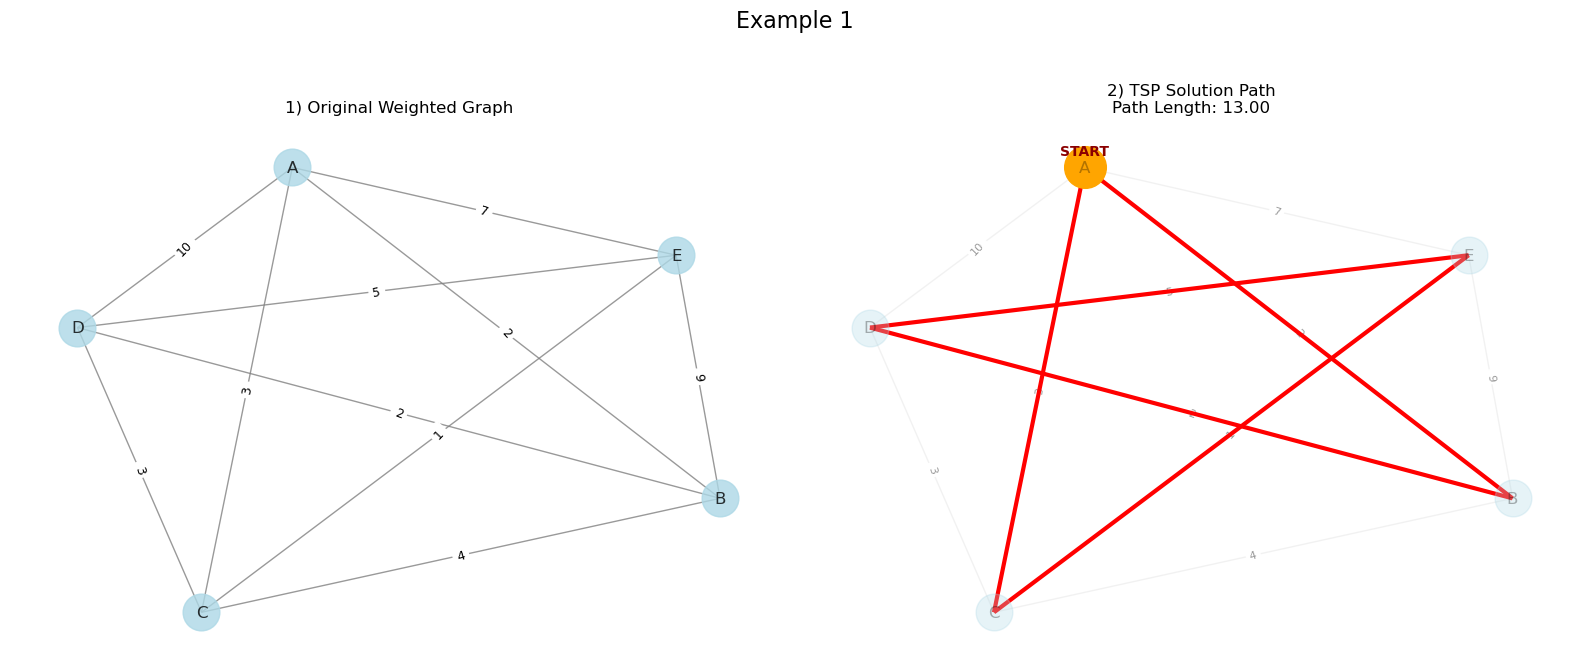

In [13]:
g1 = WeightedGraph()
edges_1 = [
    ('A', 'B', 2), ('A', 'C', 3), ('A', 'D', 10), ('A', 'E', 7),
    ('B', 'C', 4), ('B', 'D', 2), ('B', 'E', 9),
    ('C', 'D', 3), ('C', 'E', 1),
    ('D', 'E', 5)
]
for u, v, w in edges_1:
    g1.add_edge((u, v), w)

start_1 = 'A'
path_1 = solve_tsp(g1, start_1)
print(f"TSP Path 1: {' -> '.join(path_1)}")
plot_graph_and_tsp(g1, path_1, start_1, "Example 1")

### Example 2

TSP Path 2: A -> B -> D -> C -> A


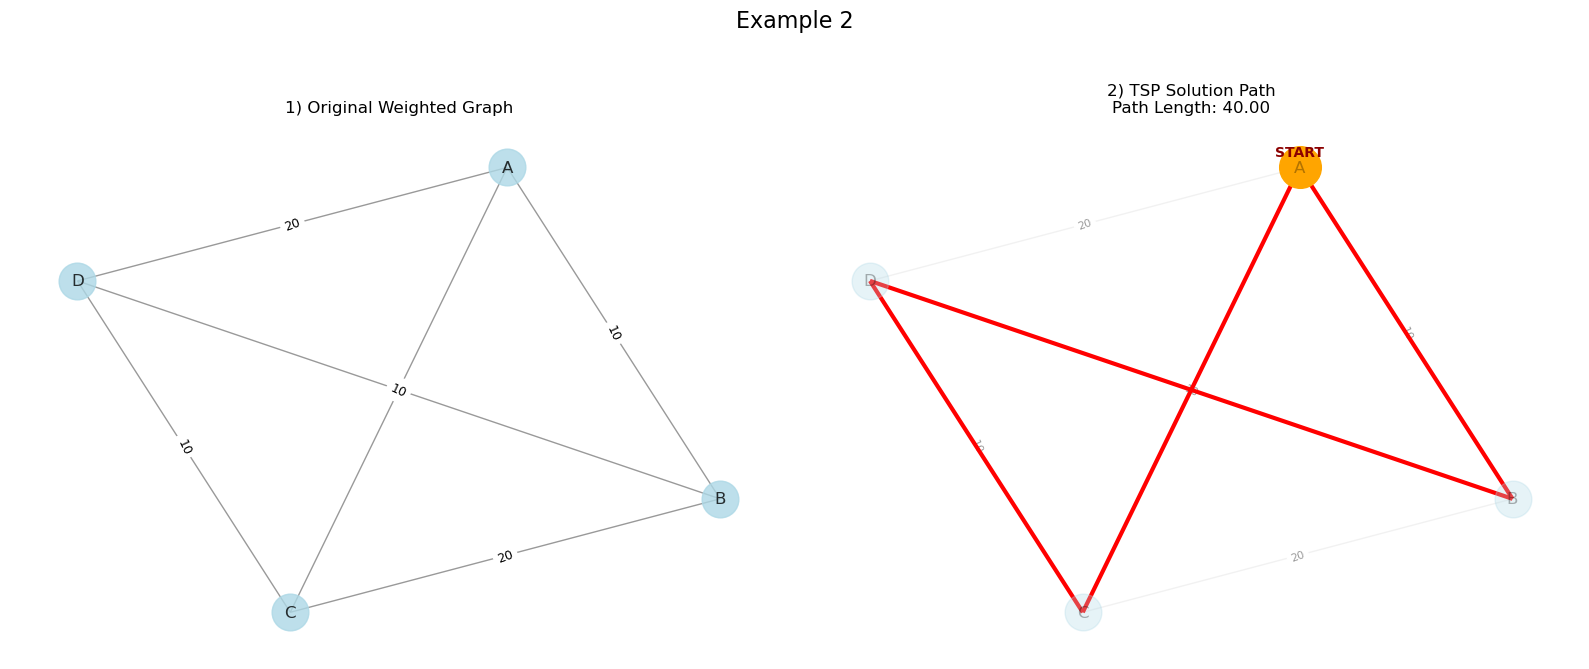

In [16]:
g2 = WeightedGraph()
edges_2 = [
    ('A', 'B', 10), ('A', 'C', 10), ('A', 'D', 20),
    ('B', 'C', 20), ('B', 'D', 10), 
    ('C', 'D', 10)
]
for u, v, w in edges_2:
    g2.add_edge((u, v), w)

start_2 = 'A'
path_2 = solve_tsp(g2, start_2)
print(f"TSP Path 2: {' -> '.join(map(str, path_2))}")
plot_graph_and_tsp(g2, path_2, start_2, "Example 2")

### Example 3

In [15]:
g3 = WeightedGraph()

edges_3 = [
    ('A', 'B', 1),
    ('B', 'C', 2),
    ('D', 'E', 1)
]

for u, v, w in edges_3:
    g3.add_edge((u, v), w)

start_3 = 'A'

path_3 = solve_tsp(g3, start_3)
print(f"TSP Path 3: {' -> '.join(path_3)}")
plot_graph_and_tsp(g3, path_3, start_3, "Example 3")

ValueError: Graph is disconnected all nodes are not reachable. 